In [48]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import re

from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.core.display import HTML

from pandas.io.json import json_normalize
import folium

import time

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

## Setup FourSquare API


In [2]:
CLIENT_ID = 'AM4LR5YZCRHYW4CLN1L0QQZLF014UPH2KI2E3L55DVDTRN2D'
CLIENT_SECRET = 'RRPFF2VTPZI3PJ0EZFLWB3LYKQA02VQ5MUZHFEN2QLI05NOL'
ACCESS_TOKEN = ''
VERSION = '20210504'
LIMIT = 50
CODE = 'M101U03NXVBA4WWD3ZEIM4CMSV4CQ3FERO22212ESYX0N5XH#_=_'
ACCESS_TOKEN = 'TKPU2YRS21T0FAB0B4551QNQ4YXKQCKSWWKVD4412RDW224T'

## Get data from FourSquare API

### Write a method to get data
FourSquare API only allows to retrieve 50 most popular results per query. In order to retrieve all the stores across Toronto, we search by NEIGHBORHOOD using the coordinates obtained in previous assignment.

In [3]:
def foursquare(lat, lnt, search_query):
    # set up the query params
    radius = 5000 # set the radius to 5km
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lnt, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

    # request
    rsp = requests.get(url)
    rsp_code = rsp.status_code
    print('{} at {}, {} response status code: {}'.format(search_query, lat, lnt, rsp_code))
    
    # extract results
    if rsp_code == 200:
        js = rsp.json()
        venues = js['response']['venues']
        df = json_normalize(venues)
    
        return df


In [2]:
# get borough coors
hoods = pd.read_csv('./trt_boroughs.csv')
coors = zip(hoods.Latitude.values, hoods.Longitude.values)

In [ ]:
'''
# search Tim Hortons in all neighborhoods
th = pd.DataFrame()

for lat, lnt in coors:
    try:
        result = foursquare(lat, lnt, 'Tim Hortons')
        th = pd.concat([th, result], ignore_index=True)
        
    except Exception as e:
        print(e)
        time.sleep(5)
        try:
            result = foursquare(lat, lnt, 'Tim Hortons')
            th = pd.concat([th, result], ignore_index=True)
        except Exception as e:
            print('Another error: ' + e)
            continue

th.to_csv('./TimHortons.csv', index=False)

# search Second Cup stores
sc = pd.DataFrame()
for lat, lnt in coors:
    try:
        result = foursquare(lat, lnt, 'Second Cup')
        sc = pd.concat([sc, result], ignore_index=True)
        
    except Exception as e:
        print(e)
        time.sleep(5)
        try:
            result = foursquare(lat, lnt, 'Second Cup')
            sc = pd.concat([sc, result], ignore_index=True)
        except Exception as e:
            print('Another error: ' + e)
            continue
            
# amend missing values
sc1 = foursquare(43.6678556, -79.53224240000002, 'Second Cup')
sc2 = foursquare(43.68641229999999, -79.4000493, 'Second Cup')
sc = pd.concat([sc, sc1, sc2], ignore_index=True)
sc.to_csv('./SecondCup.csv', index=False)
'''

### Clean data
Remove duplicates in the dfs

In [3]:
# define the 6 boroughs of Greater Toronto area
boroughs = ['Etobicoke', 'North York', 'Scarborough', 'York', 'East York', 'Toronto']

# import tim hortons results
th = pd.read_csv('./TimHortons.csv')

# clean tim hortons results
th = th[th['location.city'].isin(boroughs)] # select stores in greater toronto
th.drop_duplicates(subset='id', inplace=True) # remove duplicates
th = th.reset_index(drop=True)
print(th.shape)
th.head()

(385, 18)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4d8b9b3137c6a143040bae0c,2050 Victoria Park Ave,CA,North York,Canada,btwn Cassandra Blvd. & Rowena Dr.,1254,['2050 Victoria Park Ave (btwn Cassandra Blvd....,"[{'label': 'display', 'lat': 43.75281395751706...",43.752814,-79.314067,NaN,M1R 1V2,ON,Tim Hortons,v-1620104412
1,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,57e286f2498e43d84d92d34a,215 Brookbanks,CA,Toronto,Canada,York Miils Rd,866,"['215 Brookbanks (York Miils Rd)', 'Toronto ON...","[{'label': 'display', 'lat': 43.76066827030228...",43.760668,-79.326368,NaN,M3A 1Z5,ON,Tim Hortons,v-1620104412
2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b378dedf964a520234225e3,1244 Lawrence Ave East,CA,North York,Canada,Curlew,1558,"['1244 Lawrence Ave East (Curlew)', 'North Yor...","[{'label': 'display', 'lat': 43.74157865703848...",43.741579,-79.318966,NaN,M3A 1B9,ON,Tim Hortons,v-1620104412
3,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4bb9ef191261d13a56ffe998,Lawrence,CA,Toronto,Canada,NaN,1492,"['Lawrence', 'Toronto ON']","[{'label': 'display', 'lat': 43.74044697317023...",43.740447,-79.324169,NaN,NaN,ON,Tim Hortons / Esso,v-1620104412
4,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4ad8c5dbf964a520821421e3,2501 Victoria Park Ave.,CA,Scarborough,Canada,at Farmcrest Dr,2170,"['2501 Victoria Park Ave. (at Farmcrest Dr)', ...","[{'label': 'display', 'lat': 43.77156824953461...",43.771568,-79.320392,NaN,M1T 1A1,ON,Tim Hortons,v-1620104412


In [4]:
# import second cup results
sc = pd.read_csv('./SecondCup.csv')

# clean second cup results
sc = sc[sc['location.city'].isin(boroughs)]
sc.drop_duplicates(subset='id', inplace=True)
sc = sc.reset_index(drop=True)
print(sc.shape)
sc.head()

(67, 18)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b4ccc3bf964a5204dbf26e3,Humbertown Plaza,CA,Etobicoke,Canada,NaN,1217,"['Humbertown Plaza', 'Etobicoke ON']","[{'label': 'display', 'lat': 43.66227280880637...",43.662273,-79.519234,NaN,NaN,ON,Second Cup,v-1620104530
1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b9e7224f964a52081e436e3,3300 Bloor St W,CA,Toronto,Canada,Sun Life Centre,2621,"['3300 Bloor St W (Sun Life Centre)', 'Toronto...","[{'label': 'display', 'lat': 43.64533056349981...",43.645331,-79.522753,NaN,M8X 2W8,ON,Second Cup,v-1620104530
2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b7df51cf964a52012dc2fe3,265 Wincott Dr,CA,Toronto,Canada,NaN,1640,"['265 Wincott Dr', 'Toronto ON M9R 2R7']","[{'label': 'display', 'lat': 43.67947508876911...",43.679475,-79.544773,NaN,M9R 2R7,ON,Second Cup,v-1620104530
3,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,4e627664a80951b31884cc6b,3008A Bloor Street West,CA,Toronto,Canada,Royal York,2829,"['3008A Bloor Street West (Royal York)', 'Toro...","[{'label': 'display', 'lat': 43.64773783074008...",43.647738,-79.510773,NaN,M8X 1C2,ON,Second Cup,v-1620104530
4,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,5c86b6c6135b39002c12b888,265 Wincott Drive,CA,Toronto,Canada,NaN,1641,"['265 Wincott Drive', 'Toronto ON M9R 2R7']","[{'label': 'display', 'lat': 43.67951856654155...",43.679519,-79.544710,NaN,M9R 2R7,ON,Second Cup Coffee Co. featuring Pinkberry Froz...,v-1620104530


In [5]:
def get_zipcode(df):
    geolocator = Nominatim(user_agent='myloc', timeout=10)

    for idx in np.arange(0, df.shape[0]):
        if isinstance(df.iloc[idx, 14], float):
            try:
                address = geolocator.reverse('{}, {}'.format(df.iloc[idx, 11], df.iloc[idx, 12])).address
                df.iloc[idx, 14] = re.findall('(M.*?),', address)[0]
                
            except Exception as e:
                print('Error: idx {} got error {}'.format(idx, e))
                
    
    return df

In [6]:
def get_neighborhood(df):
    for idx in np.arange(0, df.shape[0]):
        try:
            if isinstance(df.iloc[idx, 13], float):
                df.iloc[idx, 13] = hoods[hoods.PostalCode==df.iloc[idx, 14][0:3]].Neighborhood.iloc[0]
                
        except Exception as e:
            print('Error: idx {} got error {}'.format(idx, e))
            
    return df        

In [7]:
sc = get_zipcode(sc)
sc = get_neighborhood(sc)

Error: idx 22 got error single positional indexer is out-of-bounds


In [8]:
th = get_zipcode(th)
th = get_neighborhood(th)

Error: idx 74 got error single positional indexer is out-of-bounds
Error: idx 132 got error single positional indexer is out-of-bounds
Error: idx 175 got error single positional indexer is out-of-bounds
Error: idx 219 got error single positional indexer is out-of-bounds
Error: idx 308 got error single positional indexer is out-of-bounds
Error: idx 337 got error single positional indexer is out-of-bounds
Error: idx 371 got error single positional indexer is out-of-bounds


In [9]:
# manually edit the missing values
geolocator = Nominatim(user_agent='myloc', timeout=10)

sc.iloc[22, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.654862,	-79.435366').address)[0]
sc.iloc[22, 13] = hoods[hoods.PostalCode==sc.iloc[22, 14][0:3]].Neighborhood.iloc[0]

th.iloc[74, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.655577,	-79.382873').address)[0]
th.iloc[74, 13] = hoods[hoods.PostalCode==th.iloc[74, 14][0:3]].Neighborhood.iloc[0]
th.iloc[132, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.665798,	-79.408485').address)[0]
th.iloc[132, 13] = hoods[hoods.PostalCode==th.iloc[132, 14][0:3]].Neighborhood.iloc[0]
th.iloc[175, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.783630,	-79.186716').address)[0]
th.iloc[175, 13] = hoods[hoods.PostalCode==th.iloc[175, 14][0:3]].Neighborhood.iloc[0]
th.iloc[219, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.698495,	-79.386416').address)[0]
th.iloc[219, 13] = hoods[hoods.PostalCode==th.iloc[219, 14][0:3]].Neighborhood.iloc[0]
th.iloc[308, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.779046,	-79.414906').address)[0]
th.iloc[308, 13] = hoods[hoods.PostalCode==th.iloc[308, 14][0:3]].Neighborhood.iloc[0]
th.iloc[337, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.744559,	-79.404403').address)[0]
th.iloc[337, 13] = hoods[hoods.PostalCode==th.iloc[337, 14][0:3]].Neighborhood.iloc[0]
th.iloc[371, 14] = re.findall('(M\d{1}.*?),', geolocator.reverse('43.714866,	-79.604687').address)[0]
th.iloc[371, 13] = hoods[hoods.PostalCode==th.iloc[371, 14][0:3]].Neighborhood.iloc[0]

In [65]:
th.to_csv('./trt_th.csv', index=False)
sc.to_csv('./trt_sc.csv', index=False)

In [26]:
nb = list(set(th.iloc[:, 13].values.tolist() + sc.iloc[:, 13].values.tolist()))
df = pd.DataFrame(columns=['Neighborhood', 'TimHortons', 'SecondCup'])
df.Neighborhood = nb

for idx in range(0, len(nb)):
    df.iloc[idx, 1] = th[th.iloc[:, 13]==df.iloc[idx, 0]].iloc[:, 13].count()
    df.iloc[idx, 2] = sc[sc.iloc[:, 13]==df.iloc[idx, 0]].iloc[:, 13].count()
    
df.sort_values('Neighborhood')

,Neighborhood,TimHortons,SecondCup
8,Agincourt,7,0
99,Bathurst Manor Wilson Heights Downsview North,4,0
11,Bayview Village,1,0
12,Bedford Park Lawrence Manor East,1,0
33,Berczy Park,3,1
19,Birch Cliff Cliffside West,3,0
6,Brockton Parkdale Village Exhibition Place,4,0
63,CN Tower King and Spadina Railway Lands Harbou...,13,2
79,Caledonia-Fairbanks,2,0
4,Cedarbrae,3,0


### Draw map

In [10]:
# create map object
mymap = folium.Map(location=[43.7181557, -79.5181405], zoom_start=11)


# draw tim hortons first in red
th_lats = th.iloc[:, 11].values
th_lnts = th.iloc[:, 12].values
for th_lat, th_lnt in zip(th_lats, th_lnts):
    folium.CircleMarker([th_lat, th_lnt],
                       radius=5,
                       color='red').add_to(mymap)
    
# draw second cups in blue
sc_lats = sc.iloc[:, 11].values
sc_lnts = sc.iloc[:, 12].values
for sc_lat, sc_lnt in zip(sc_lats, sc_lnts):
    folium.CircleMarker([sc_lat, sc_lnt],
                       radius=5,
                       color='blue').add_to(mymap)
    
mymap

### Clustering
Two models are created using k-means for Tim Hortons and Second Cup respectively.

In [88]:
# Define a method to calculate the best number of clusters
def best_k(X):
    line = []
    for k in range(1, 10):
        km = KMeans(n_clusters = k, random_state=0).fit(X)
        labels = km.labels_
        center = km.cluster_centers_
        line.append(sum(np.min(cdist(df.iloc[:, 1:3], center, 'euclidean'), axis=1)) / df.shape[0])

    plt.plot(list(range(1, 10)), line, 'bx-')
    plt.xlabel('k')
    plt.title('The Elbow Method showing the best k')
    plt.show()

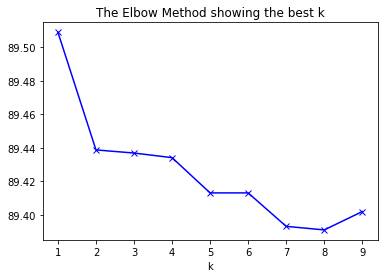

In [89]:
# Cluster Tim Hortons
X_th = th.iloc[:, [11, 12]]
best_k(X_th)

In [91]:
km_th = KMeans(n_clusters=7, random_state=0).fit(X_th)
th['label'] = km_th.labels_

# map the clusters with folium
thmap = folium.Map(location=[43.7181557, -79.5181405], zoom_start=11)

for idx in th.index.values:
    coor = [th.iloc[idx, 11], th.iloc[idx, 12]]
    if th.iloc[idx, 18] == 0:
        marker_color = 'lightred'
    elif th.iloc[idx, 18] == 1:
        marker_color = 'cadetblue'
    else:
        marker_color = 'lightgreen'
    marker = folium.Marker(location=coor, icon=folium.Icon(color=marker_color))
    marker.add_to(thmap)
    
display(thmap)

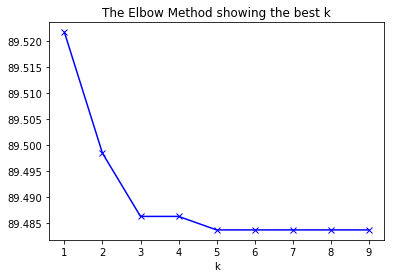

In [90]:
# Cluster Second Cup
X_sc = sc.iloc[:, [11, 12]]
best_k(X_sc)

In [93]:
km_sc = KMeans(n_clusters=3, random_state=0).fit(X_sc)
sc['label'] = km_sc.labels_

# map sce clusters wisc folium
scmap = folium.Map(location=[43.7181557, -79.5181405], zoom_start=11)

for idx in sc.index.values:
    coor = [sc.iloc[idx, 11], sc.iloc[idx, 12]]
    if sc.iloc[idx, 18] == 0:
        marker_color = 'lightred'
    elif sc.iloc[idx, 18] == 1:
        marker_color = 'cadetblue'
    else:
        marker_color = 'lightgreen'
    marker = folium.Marker(location=coor, icon=folium.Icon(color=marker_color))
    marker.add_to(scmap)
    
display(scmap)